
1. Ordinary Decision Trees

In [72]:
import itertools
import numpy as np
from scipy.stats import norm
from prettytable import PrettyTable

import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [73]:
# from google.colab import drive
# drive.mount('/content/drive')

In [74]:
raw_data = pd.read_csv('./PAMAP2_data.csv')
print(raw_data.shape)
raw_data.head()

(2872533, 54)


,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0


In [75]:
# Define a function to clean data
def clean_data(data):
    # Remove certain columns
    data = data.dropna()
    data = data.drop(['timestamp'], axis=1)
    # Remove the orientation columns
    data = data.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4'], axis=1)
    data = data.drop(['chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4'], axis=1)
    data = data.drop(['ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'], axis=1)

    # For the heart rate, fill missing values with previous timestamp's heart rate
    data['heartrate'] = data['heartrate'].fillna(method='ffill')

    # Normalize the data
    # data = (data - data.mean()) / data.std()
    # discard data with NaN values
    data = data.dropna()
    data = data.reset_index(drop=True)

    # disacrd data with activityID = 0
    data = data[data['activityID'] != 0]
    data = data.reset_index(drop=True)

    # Shuffle the data
    data = data.sample(frac=1).reset_index(drop=True)
    return data

In [76]:
data = clean_data(raw_data)
print(data.shape)
data.head()

(175498, 41)


,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,handGyro1,...,ankleAcc16_3,ankleAcc6_1,ankleAcc6_2,ankleAcc6_3,ankleGyro1,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3
0,7,127.0,30.1875,-12.20430,9.35000,2.365910,-12.14050,10.57280,2.640760,-1.203020,...,-3.341490,13.82660,10.117300,-3.275850,-2.247740,0.278920,-1.824910,-40.26840,-5.73797,10.7367
1,2,81.0,32.8750,-2.81909,5.15412,8.101310,-2.66129,5.20843,7.973390,-0.042710,...,-0.180866,9.36400,4.660780,0.488665,0.097309,-0.032734,0.000378,-2.43416,-5.11275,23.5315
2,3,91.0,35.0625,2.84920,9.48275,0.743553,3.21021,9.58447,0.951038,0.227852,...,-3.389100,9.31776,-0.924661,-3.019630,0.026823,-0.052877,0.007881,-21.72500,18.66300,32.2296
3,4,125.0,31.8125,-8.75382,2.06343,0.979654,-8.82180,1.74272,1.071130,3.998990,...,-2.245360,3.10259,-0.985345,-2.032900,1.815450,-0.884513,3.999410,-38.82120,-5.12537,10.6076
4,17,81.0,33.3750,-5.55331,8.91137,5.815420,-5.69738,8.12817,6.022100,3.413240,...,-0.638953,9.82431,-1.133090,-0.403254,0.269806,-0.061488,-0.126263,-37.93570,11.90400,41.8250


In [77]:
y = data['activityID']
y = y.replace({1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 12: 7, 13: 8, 16: 9, 17: 10, 24: 11})
X = data.drop(['activityID'], axis=1)

print("Shape of X:", X.shape)
print("Shape of Y:", y.shape)


Shape of X: (175498, 40)
Shape of Y: (175498,)


In [78]:
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

In [79]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


print("Shape of training data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)
print("Shape of training labels: ", y_train.shape)
print("Shape of test labels: ", y_test.shape)

Shape of training data:  (140398, 40)
Shape of test data:  (35100, 40)
Shape of training labels:  (140398,)
Shape of test labels:  (35100,)


In [80]:
X_train = X_train[:2000]
y_train = y_train[:2000]

In [81]:
def decision_tree_classifier(X, y, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a decision tree classifier
    clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf, 
                                  max_features=max_features)

    # Train the classifier on the training data
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Compute the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy


In [82]:
# Define the different possible values for each parameter
criterion = ['gini', 'entropy']

# higher the max_depth is, more likely the model will overfit
max_depth = [None, 5, 10, 15]

# As per the same paper mentioned above
min_samples_split = [2, 5, 10]

# less value will overfit and high value will under-fit
# according to the paper, "An empirical study on hyperparameter tuning of decision trees", min_samples_leaf tend to be between 1 and 20
min_samples_leaf = [1, 5, 10, 15]

# sqrt(n_features) and log2(n_features) are close to 5 here so we have taken 5 to reduce computation time
# usually lesser values for max_features leads to better results as it tends to prevent over-fitting
# so we have taken None, 3, 5 and 10 to explore all angles around this parameter
max_features = [None, 3, 5, 10]

# Create a list of all possible combinations of parameter values
parameter_combinations = list(itertools.product(criterion, max_depth, min_samples_split, min_samples_leaf, max_features))

t = PrettyTable(['Criterion', 'Max Depth', 'Min Samples Split', 'Min Samples Leaf', 'Max Features', 'Accuracy'])
# Test the decision tree classifier with different parameter combinations



for params in tqdm.tqdm(parameter_combinations):
    criterion, max_depth, min_samples_split, min_samples_leaf, max_features = params
    accuracy = decision_tree_classifier(X, y, criterion=criterion, max_depth=max_depth, 
                                         min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                                         max_features=max_features)
    
    t.add_row([criterion, max_depth, min_samples_split, min_samples_leaf, max_features, accuracy*100])

print(t)

100%|██████████| 384/384 [27:45<00:00,  4.34s/it]

+-----------+-----------+-------------------+------------------+--------------+--------------------+
| Criterion | Max Depth | Min Samples Split | Min Samples Leaf | Max Features |      Accuracy      |
+-----------+-----------+-------------------+------------------+--------------+--------------------+
|    gini   |    None   |         2         |        1         |     None     | 98.36182336182337  |
|    gini   |    None   |         2         |        1         |      3       | 90.95726495726495  |
|    gini   |    None   |         2         |        1         |      5       | 91.54985754985755  |
|    gini   |    None   |         2         |        1         |      10      | 96.81766381766381  |
|    gini   |    None   |         2         |        5         |     None     | 98.04273504273505  |
|    gini   |    None   |         2         |        5         |      3       | 87.41595441595442  |
|    gini   |    None   |         2         |        5         |      5       | 90.44729344

In [83]:
# mean accuracy of the models with different parameter combinations with max-depth fixed

gini_accuracy = [[] for i in range(4)]
entropy_accuracy = [[] for i in range(4)]


for row in t:
    row.header = False
    row.border = False
    # print(row.rows[0][0])
    if row.rows[0][0] == 'gini':
        if row.rows[0][1] == None:
            gini_accuracy[3].append(row.rows[0][-1])
        elif row.rows[0][1] == 5:
            gini_accuracy[0].append(row.rows[0][-1])
        elif row.rows[0][1] == 10:
            gini_accuracy[1].append(row.rows[0][-1])
        elif row.rows[0][1] == 15:
            gini_accuracy[2].append(row.rows[0][-1])
        # gini_accuracy.append(row.rows[0][-1])
    elif row.rows[0][0] == 'entropy':
        if row.rows[0][1] == None:
            entropy_accuracy[3].append(row.rows[0][-1])
        elif row.rows[0][1] == 5:
            entropy_accuracy[0].append(row.rows[0][-1])
        elif row.rows[0][1] == 10:
            entropy_accuracy[1].append(row.rows[0][-1])
        elif row.rows[0][1] == 15:
            entropy_accuracy[2].append(row.rows[0][-1])
        # entropy_accuracy.append(row.rows[0][-1])




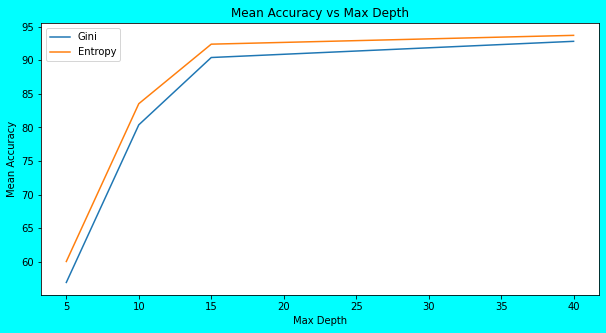

In [84]:
mean_gini_accuracy = [np.mean(gini_accuracy[0]), np.mean(gini_accuracy[1]), np.mean(gini_accuracy[2]), np.mean(gini_accuracy[3])]
mean_entropy_accuracy = [np.mean(entropy_accuracy[0]), np.mean(entropy_accuracy[1]), np.mean(entropy_accuracy[2]), np.mean(entropy_accuracy[3])]

# plot barplot for mean accuracy of the models with different parameter combinations with max-depth fixed
plt.figure(figsize=(10, 5), facecolor='cyan')
plt.plot([5, 10, 15, 40], mean_gini_accuracy, label='Gini')
plt.plot([5, 10, 15, 40], mean_entropy_accuracy, label='Entropy')
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Max Depth')
plt.legend()
plt.show()


In [101]:
gini_accuracy2 = [[] for i in range(3)]
entropy_accuracy2 = [[] for i in range(3)]


for row in t:
    row.header = False
    row.border = False
    
    if row.rows[0][0] == 'gini':
        if row.rows[0][2] == 2:
            gini_accuracy2[0].append(row.rows[0][-1])
        elif row.rows[0][2] == 5:
            gini_accuracy2[1].append(row.rows[0][-1])
        elif row.rows[0][2] == 10:
            gini_accuracy2[2].append(row.rows[0][-1])
      
    elif row.rows[0][0] == 'entropy':
        if row.rows[0][2] == 2:
            entropy_accuracy2[0].append(row.rows[0][-1])
        elif row.rows[0][2] == 5:
            entropy_accuracy2[1].append(row.rows[0][-1])
        elif row.rows[0][2] == 10:
            entropy_accuracy2[2].append(row.rows[0][-1])

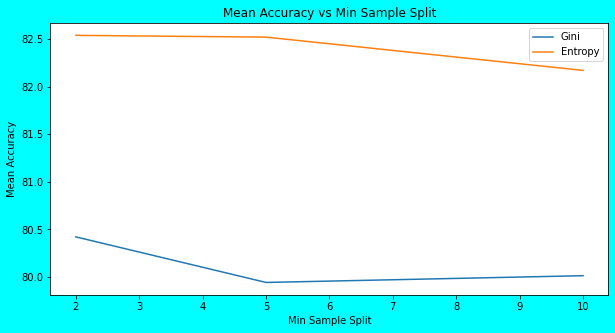

In [102]:
mean_gini_accuracy2 = [np.mean(gini_accuracy2[0]), np.mean(gini_accuracy2[1]), np.mean(gini_accuracy2[2])]
mean_entropy_accuracy2 = [np.mean(entropy_accuracy2[0]), np.mean(entropy_accuracy2[1]), np.mean(entropy_accuracy2[2])]

# plot barplot for mean accuracy of the models with different parameter combinations with max-depth fixed
plt.figure(figsize=(10, 5), facecolor='cyan')
plt.plot([2, 5, 10], mean_gini_accuracy2, label='Gini')
plt.plot([2, 5, 10], mean_entropy_accuracy2, label='Entropy')
plt.xlabel('Min Sample Split')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Min Sample Split')
plt.legend()
plt.show()

In [103]:
gini_accuracy3 = [[] for i in range(4)]
entropy_accuracy3 = [[] for i in range(4)]


for row in t:
    row.header = False
    row.border = False
    
    if row.rows[0][0] == 'gini':
        if row.rows[0][3] == 1:
            gini_accuracy3[0].append(row.rows[0][-1])
        elif row.rows[0][3] == 5:
            gini_accuracy3[1].append(row.rows[0][-1])
        elif row.rows[0][3] == 10:
            gini_accuracy3[2].append(row.rows[0][-1])
        elif row.rows[0][3] == 15:
            gini_accuracy3[3].append(row.rows[0][-1])
        
    elif row.rows[0][0] == 'entropy':
        if row.rows[0][3] == 1:
            entropy_accuracy3[0].append(row.rows[0][-1])
        elif row.rows[0][3] == 5:
            entropy_accuracy3[1].append(row.rows[0][-1])
        elif row.rows[0][3] == 10:
            entropy_accuracy3[2].append(row.rows[0][-1])
        elif row.rows[0][3] == 15:
            entropy_accuracy3[3].append(row.rows[0][-1])
    

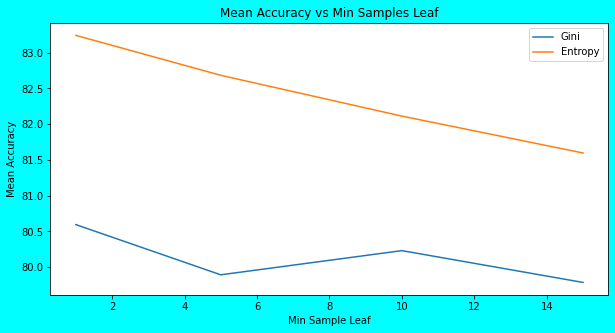

In [104]:
mean_gini_accuracy3 = [np.mean(gini_accuracy3[0]), np.mean(gini_accuracy3[1]), np.mean(gini_accuracy3[2]), np.mean(gini_accuracy3[3])]
mean_entropy_accuracy3 = [np.mean(entropy_accuracy3[0]), np.mean(entropy_accuracy3[1]), np.mean(entropy_accuracy3[2]), np.mean(entropy_accuracy3[3])]

# plot barplot for mean accuracy of the models with different parameter combinations with max-depth fixed
plt.figure(figsize=(10, 5), facecolor='cyan')
plt.plot([1, 5, 10, 15], mean_gini_accuracy3, label='Gini')
plt.plot([1, 5, 10, 15], mean_entropy_accuracy3, label='Entropy')
plt.xlabel('Min Sample Leaf')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Min Samples Leaf')
plt.legend()
plt.show()

In [105]:
gini_accuracy4 = [[] for i in range(4)]
entropy_accuracy4 = [[] for i in range(4)]


for row in t:
    row.header = False
    row.border = False
    
    if row.rows[0][0] == 'gini':
        if row.rows[0][4] == None:
            gini_accuracy4[3].append(row.rows[0][-1])
        elif row.rows[0][4] == 3:
            gini_accuracy4[0].append(row.rows[0][-1])
        elif row.rows[0][4] == 5:
            gini_accuracy4[1].append(row.rows[0][-1])
        elif row.rows[0][4] == 10:
            gini_accuracy4[2].append(row.rows[0][-1])
       
    elif row.rows[0][0] == 'entropy':
        if row.rows[0][4] == None:
            entropy_accuracy4[3].append(row.rows[0][-1])
        elif row.rows[0][4] == 3:
            entropy_accuracy4[0].append(row.rows[0][-1])
        elif row.rows[0][4] == 5:
            entropy_accuracy4[1].append(row.rows[0][-1])
        elif row.rows[0][4] == 10:
            entropy_accuracy4[2].append(row.rows[0][-1])
      


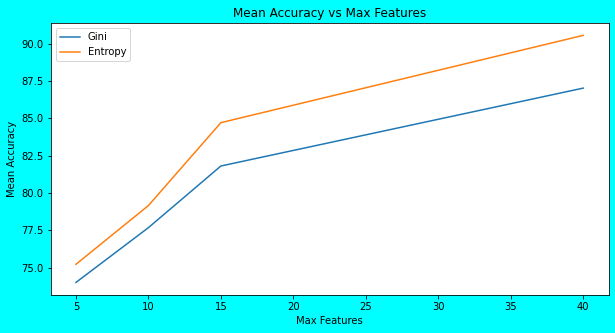

In [106]:
mean_gini_accuracy4 = [np.mean(gini_accuracy4[0]), np.mean(gini_accuracy4[1]), np.mean(gini_accuracy4[2]), np.mean(gini_accuracy4[3])]
mean_entropy_accuracy4 = [np.mean(entropy_accuracy4[0]), np.mean(entropy_accuracy4[1]), np.mean(entropy_accuracy4[2]), np.mean(entropy_accuracy4[3])]

# plot barplot for mean accuracy of the models with different parameter combinations with max-depth fixed
plt.figure(figsize=(10, 5), facecolor='cyan')
plt.plot([5, 10, 15, 40], mean_gini_accuracy4, label='Gini')
plt.plot([5, 10, 15, 40], mean_entropy_accuracy4, label='Entropy')
plt.xlabel('Max Features')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Max Features')
plt.legend()
plt.show()


In [91]:
from sklearn.model_selection import cross_validate

def decision_tree_classifier_Validate(X, y, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None):
    clf = DecisionTreeClassifier(max_depth=max_depth)
    # Train the classifier on the training data
    result = cross_validate(clf, X, y, cv=5, return_train_score=True)

    return result

In [92]:
max_depth_train_accuracies = []
max_depth_test_accuracies = []

for i in tqdm.tqdm(range(1, 40)):
    result = decision_tree_classifier_Validate(X, y, criterion='gini', max_depth=i)
    max_depth_train_accuracies.append(np.mean(result['train_score']))
    max_depth_test_accuracies.append(np.mean(result['test_score']))

100%|██████████| 39/39 [29:04<00:00, 44.74s/it]


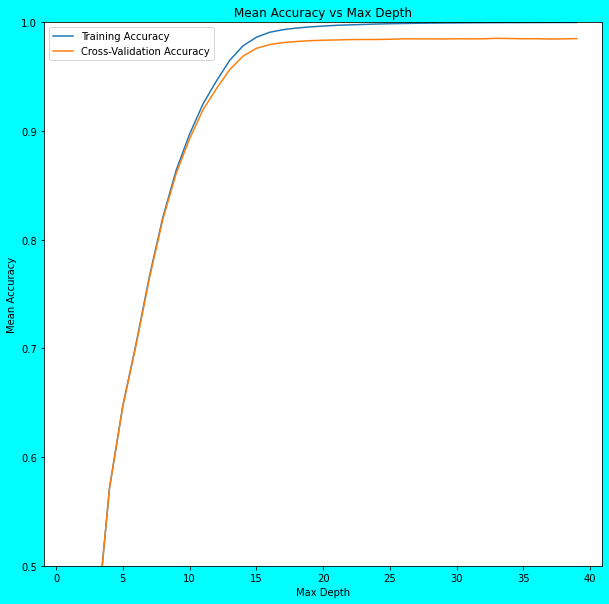

0.9851679270413707


In [93]:
plt.figure(figsize=(10, 10), facecolor='cyan')
plt.plot([i for i in range(1, 40)], max_depth_train_accuracies, label='Training Accuracy')
plt.plot([i for i in range(1, 40)], max_depth_test_accuracies, label='Cross-Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Mean Accuracy')
plt.ylim(0.5, 1)
plt.title('Mean Accuracy vs Max Depth')
plt.legend()
plt.show()

print(max(max_depth_test_accuracies))


2. Boosting Decision Trees


In [94]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

def boosting_decision_tree_classifier(X, y, estimator_num=100, learn_rate=0.01):
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initisalize the AdaBoost Classifier
    clf = AdaBoostClassifier(random_state=96, base_estimator=RandomForestClassifier(random_state=101), n_estimators=estimator_num, learning_rate=learn_rate)

    # Train the classifier on the training data
    clf.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = clf.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)

    # Print the accuracy
    # print('Accuracy:', accuracy*100)
    return accuracy

In [107]:
print("Accuracy after using Adaboost:", boosting_decision_tree_classifier(X, y, estimator_num=100, learn_rate=0.01)*100)

Accuracy after using Adaboost: 0.9943019943019943


3. Random Forest

In [109]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(X, y, n = 100):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize a random forest classifier
    clf = RandomForestClassifier(n_estimators= n, random_state=42)

    # Train the classifier on the training data
    clf.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = clf.predict(X_test)

    # Calculate the accuracy of the classifier
    accuracy = accuracy_score(y_test, y_pred)

    # Print the accuracy
    return accuracy

In [110]:
random_forest(X, y)

0.994957264957265

100%|██████████| 15/15 [28:08<00:00, 112.56s/it]


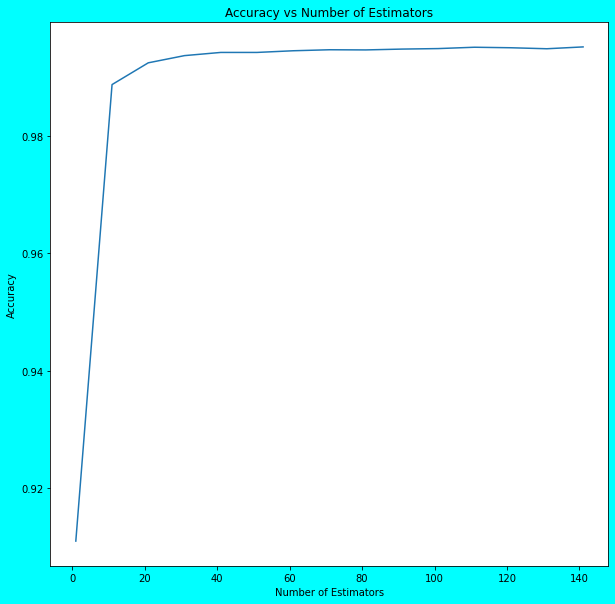

Maximum accuracy: 0.9951282051282051 at n = 141


In [111]:
accuracy_random_forest = []

for i in tqdm.tqdm(range(1, 150, 10)):
    accuracy_random_forest.append(random_forest(X, y, n=i))

plt.figure(figsize=(10, 10), facecolor='cyan')
plt.plot([i for i in range(1, 150, 10)], accuracy_random_forest)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Estimators')
plt.show()

print("Maximum accuracy:", max(accuracy_random_forest), "at n =", accuracy_random_forest.index(max(accuracy_random_forest))*10 + 1)